<a href="https://colab.research.google.com/github/ayfeng23/llada_custom_scheduler/blob/main/log_loss_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Initialization
#import packages
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, get_scheduler
from tqdm import tqdm
import random
from scipy.stats import beta
import numpy as np
from datasets import load_dataset
import pandas as pd
from wordfreq import word_frequency

/home/ayf4/.conda/envs/llada-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
MASK_TOKEN_ID = 126336  # [MASK] token for LLaDA

tokenizer = AutoTokenizer.from_pretrained("GSAI-ML/LLaDA-8B-Instruct", trust_remote_code=True)
vocab_dict = tokenizer.get_vocab()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
        "GSAI-ML/LLaDA-8B-Instruct",
        trust_remote_code=True,
        device_map="auto",
        torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    )

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.
Loading checkpoint shards: 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]
Some parameters are on the meta device because they were offloaded to the cpu.


In [ ]:
#@title Dataset
def is_valid(example):#checks if dataset follows instruct format of user-assistant dialogue, if so, take first pair of dialogue
    messages = example["messages"]
    return (
        len(messages) >= 2 and
        messages[0]["role"] == "user" and
        messages[1]["role"] == "assistant" and
        all(item["content"].strip() != "" for item in messages[:2])
    )

class SFTDataset(Dataset):
    def __init__(self, tokenizer, sect, max_len=512):
        self.samples = []
        self.tokenizer = tokenizer

        ds = load_dataset("allenai/llama-3-tulu-v2-sft-subset")["raw"]
        print("Length before filtering: ", len(ds))
        ds = ds.filter(is_valid)
        ds = ds.filter(lambda ex: len(ex["messages"]) >= 2
                                  and ex["messages"][0]["role"] == "user"
                                  and ex["messages"][1]["role"] == "assistant"
                                  and ex["messages"][1]["content"].strip() != "")

        print("Length after filtering: ", len(ds))
        if sect == "train":
            ds = ds.select(range(10000))
        else:
            ds = ds.select(range(10000, len(ds)))

        for ex in ds:
            prompt = ex["messages"][0]["content"]
            answer = ex["messages"][1]["content"]

            prompt_text = "<s><|startofuser|>\n" + prompt + "<|endofuser|><|startofassistant|>\n"
            answer_text = answer + "<|endoftext|>"

            prompt_ids = tokenizer(prompt_text, return_tensors="pt", truncation=True, max_length=max_len).input_ids[0]
            answer_ids = tokenizer(answer_text, return_tensors="pt", truncation=True, max_length=max_len).input_ids[0]

            # Merge and pad
            input_ids = torch.cat([prompt_ids, answer_ids])
            input_ids = input_ids[:max_len]
            pad_len = max_len - input_ids.size(0)
            if pad_len > 0:
                input_ids = torch.cat([input_ids, torch.tensor([tokenizer.pad_token_id] * pad_len)])
            self.samples.append({
                "input_ids": input_ids,
                "prompt_length": torch.tensor(len(prompt_ids)),
                "answer_length": torch.tensor(len(answer_ids)),
                "prompt_ids": prompt_ids,
                "answer_ids": answer_ids
            })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [ ]:
model.eval()
eval_dataset = SFTDataset(tokenizer, sect="test", max_len=128)

Length before filtering:  69605
Length after filtering:  11932


In [ ]:
#@title IDF Score Setup
#Detailed comments in idf_forward_process.ipynb
from transformers import AutoTokenizer
from wordfreq import word_frequency
threshold = 1e-6

tokenizer = AutoTokenizer.from_pretrained("GSAI-ML/LLaDA-8B-Instruct", trust_remote_code=True)
llada_vocab = tokenizer.get_vocab()
llada_tokens = list(llada_vocab.keys())
print("Tokenizer vocab size:", len(llada_vocab))
llada_tokens_cleaned = llada_tokens
real_words = [
    t for t in llada_tokens_cleaned
    if word_frequency(t, "en") > threshold or word_frequency(t[1:], "en") > threshold
]
non_words = [t for t in llada_tokens_cleaned if t not in real_words]

idf_df = pd.read_csv("LLaDA/wiki_tfidf_terms.csv")
idf_terms = set(str(t).lower() for t in idf_df['token'].dropna())

Tokenizer vocab size: 126349


In [ ]:
tokens_in_wiki = [t for t in real_words if t.lower() in idf_terms or t[1:].lower() in idf_terms]

percent_overlap = 100 * len(tokens_in_wiki) / len(real_words)

# Output
print(f"LLaDA real English vocab tokens total        : {len(real_words)}")
print(f"Tokens found in wiki_tfidf     : {len(tokens_in_wiki)}")
print(f"Percentage of LLaDA real English vocab in wiki IDF set: {percent_overlap:.2f}%")

LLaDA real English vocab tokens total        : 54872
Tokens found in wiki_tfidf     : 54238
Percentage of LLaDA real English vocab in wiki IDF set: 98.84%


In [ ]:
idf_values = idf_df['idf'].dropna()
real_words_lower = set(t.lower() for t in real_words)
idf_real = idf_df[idf_df['token'].str.lower().isin(real_words_lower)]
idf_real_values = idf_real['idf'].dropna()
idf_df = idf_df.dropna(subset=['idf'])
idf_min = idf_df['idf'].min()
idf_max = idf_df['idf'].max()

# Apply min-max normalization
idf_df['idf_norm'] = (idf_df['idf'] - idf_min) / (idf_max - idf_min)
idf_real['idf_norm'] = (idf_real['idf'] - idf_min) / (idf_max - idf_min)

idf_real_values_norm = idf_real['idf_norm'].dropna()
mean_idf_norm = idf_real_values_norm.mean()

idf_dict = {
    (token, token_id): mean_idf_norm
    for token, token_id in vocab_dict.items()
}
idf_lookup = {
    str(row['token']): row['idf_norm']
    for _, row in idf_df.dropna(subset=['token', 'idf_norm']).iterrows()
}
print("Lookup Complete")

Lookup Complete


In [ ]:
for (token, token_id), idf_val in idf_dict.items():
    if token in idf_lookup:
        idf_dict[(token, token_id)] = idf_lookup[token]

In [ ]:
for (token, token_id), idf_val in idf_dict.items():
    if idf_val == mean_idf_norm and len(token) > 1:
        token_dropped = token[1:]
        if token_dropped in idf_lookup:
            idf_dict[(token, token_id)] = idf_lookup[token_dropped]

In [ ]:
for (token, token_id), idf_val in idf_dict.items():
    if idf_val == mean_idf_norm:
        token_lower = token.lower()
        if token_lower in idf_lookup:
            idf_dict[(token, token_id)] = idf_lookup[token_lower]

for (token, token_id), idf_val in idf_dict.items():
    if idf_val == mean_idf_norm and len(token) > 1:
        token_dropped_lower = token[1:].lower()
        if token_dropped_lower in idf_lookup:
            idf_dict[(token, token_id)] = idf_lookup[token_dropped_lower]

In [ ]:
def build_tokenid_to_priority(vocab_dict, rand_dict, default_priority=0.5):
    max_id = max(vocab_dict.values()) + 1
    table = np.full(max_id, default_priority)
    for (_, token_id), priority in rand_dict.items():
        table[token_id] = priority
    return table

tokenid_to_priority = build_tokenid_to_priority(vocab_dict, idf_dict)

In [ ]:
tokenid_to_priority_orig = np.copy(tokenid_to_priority)

In [ ]:
#testing if manually overriding overweight tokens will help
manual_idf_overrides = {
    tokenizer.pad_token_id: 0.0,
    tokenizer.eos_token_id: 0.0,
    tokenizer.bos_token_id: 0.0,
    tokenizer.unk_token_id: 0.0,

    tokenizer.convert_tokens_to_ids("<|endoftext|>"): 0.0,
    tokenizer.convert_tokens_to_ids("<|startofuser|>"): 0.1,
    tokenizer.convert_tokens_to_ids("<|endofuser|>"): 0.1,
    tokenizer.convert_tokens_to_ids("<|startofassistant|>"): 0.1,

    tokenizer.convert_tokens_to_ids("<s>"): 0.0,
    tokenizer.convert_tokens_to_ids("</s>"): 0.0,
    tokenizer.convert_tokens_to_ids("<s"): 0.0,  # note: GPT-style token?

    tokenizer.convert_tokens_to_ids("\n"): 0.0,
    tokenizer.convert_tokens_to_ids("\n"): 0.0,
    tokenizer.convert_tokens_to_ids("⏎"): 0.0,  # visual replacement of newline
    tokenizer.convert_tokens_to_ids("|"): 0.0,
    tokenizer.convert_tokens_to_ids(">"): 0.0,
    tokenizer.convert_tokens_to_ids("<"): 0.0,
    tokenizer.convert_tokens_to_ids("><"): 0.0,
    tokenizer.convert_tokens_to_ids("|>"): 0.0,
    tokenizer.convert_tokens_to_ids(":<"): 0.0,
    tokenizer.convert_tokens_to_ids("\""): 0.0,
    tokenizer.convert_tokens_to_ids("'"): 0.0,
    tokenizer.convert_tokens_to_ids("’"): 0.0,
    tokenizer.convert_tokens_to_ids("“"): 0.0,
    tokenizer.convert_tokens_to_ids("”"): 0.0,
    198: 0.0,
    220: 0.0,
    13: 0.2,
    25: 0.2,
    11: 0.2,
    7442: 0.2,
    477: 0.2,
    5771: 0.0,
    10450: 0.1,
}


In [ ]:
for token_id, new_idf in manual_idf_overrides.items():
    if token_id is not None:
        tokenid_to_priority[token_id] = new_idf


In [ ]:
#@title Cross-Entropy Evaluation
#Calculate Log Loss from Predicting Sequence Given Partially Masked Token
#Two options of top_idf masking and random masking and resample randomly from top_idf
import torch.nn.functional as F
def evaluate_masking_log_loss(
    eval_dataset,
    tokenizer,
    model,
    tokenid_to_priority,
    MASK_TOKEN_ID,
    n,
    use_top_idf=True,
    use_random_masking=True,
    max_batches=None,
    device="cuda",
    print_every_batches=10,
    idf_sample_ratio=1.0  # ← new param
):
    assert isinstance(n, (int, float)), "n must be int or float"
    assert 0 < idf_sample_ratio <= 1.0, "idf_sample_ratio must be in (0, 1]"

    log_losses_top_idf = []
    log_losses_random = []

    for i, batch in enumerate(eval_dataset):
        if max_batches is not None and i >= max_batches:
            break

        input_ids = batch["input_ids"].to(device)
        prompt_lengths = batch["prompt_length"].to(device)

        if input_ids.dim() == 1:
            input_ids = input_ids.unsqueeze(0)
        if prompt_lengths.dim() == 1:
            prompt_lengths = prompt_lengths.unsqueeze(0)

        input_ids_np = input_ids.cpu().numpy()

        for b in range(input_ids.size(0)):
            prompt_len = prompt_lengths.item() if prompt_lengths.dim() == 0 else prompt_lengths[b].item()
            full_seq = input_ids[b]
            answer_ids = input_ids_np[b][prompt_len:]
            priorities = tokenid_to_priority[input_ids_np[b]]
            answer_priorities = priorities[prompt_len:]

            answer_len = len(answer_ids)
            if answer_len == 0:
                continue
            k = max(1, int(n * answer_len)) if isinstance(n, float) else min(n, answer_len)

            full_text = tokenizer.decode(input_ids[b], skip_special_tokens=True)
            top_idf_text, rand_text = None, None

            if use_top_idf: #masking out top idfs
                topk_idx = np.argsort(answer_priorities)[-k:]
                sampled_k = max(1, int(idf_sample_ratio * len(topk_idx)))
                sampled_idx = np.random.choice(topk_idx, sampled_k, replace=False)

                keep_mask = np.zeros(answer_len, dtype=bool)
                keep_mask[sampled_idx] = True
                full_mask = torch.ones_like(full_seq, dtype=torch.bool)
                full_mask[prompt_len:] = ~torch.tensor(keep_mask, dtype=torch.bool)
                masked_input = input_ids.clone()
                masked_input[b][full_mask] = MASK_TOKEN_ID

                with torch.autocast(device_type=device, dtype=torch.bfloat16 if device == "cuda" else torch.float32):
                    outputs = model(input_ids=masked_input)
                logits = outputs.logits[b]
                target = input_ids[b, prompt_len+1:]
                pred_logits = logits[prompt_len:-1]
                if pred_logits.shape[0] == target.shape[0]:
                    loss = F.cross_entropy(pred_logits, target, reduction='mean')
                    log_losses_top_idf.append(loss.item())

                top_idf_text = tokenizer.decode(masked_input[b], skip_special_tokens=True)

            if use_random_masking: #mask out random idfs
                rand_idx = np.random.choice(answer_len, k, replace=False)
                keep_mask = np.zeros(answer_len, dtype=bool)
                keep_mask[rand_idx] = True
                full_mask = torch.ones_like(full_seq, dtype=torch.bool)
                full_mask[prompt_len:] = ~torch.tensor(keep_mask, dtype=torch.bool)
                masked_input = input_ids.clone()
                masked_input[b][full_mask] = MASK_TOKEN_ID

                with torch.autocast(device_type=device, dtype=torch.bfloat16 if device == "cuda" else torch.float32):
                    outputs = model(input_ids=masked_input)
                logits = outputs.logits[b]
                target = input_ids[b, prompt_len+1:]
                pred_logits = logits[prompt_len:-1]
                if pred_logits.shape[0] == target.shape[0]:
                    loss = F.cross_entropy(pred_logits, target, reduction='mean')
                    log_losses_random.append(loss.item())

                rand_text = tokenizer.decode(masked_input[b], skip_special_tokens=True)
        if (i + 1) % print_every_batches == 0:
            top_avg = np.mean(log_losses_top_idf) if log_losses_top_idf else float('nan')
            rand_avg = np.mean(log_losses_random) if log_losses_random else float('nan')
            print(f"[Batch {i + 1}] → "
                  f"Top-IDF Loss Avg: {top_avg:.4f} | "
                  f"Random Loss Avg: {rand_avg:.4f}")

    return log_losses_top_idf, log_losses_random

In [ ]:
#Option to test fine-tuned baseline
from transformers import AutoModel
from peft import PeftModel
import torch
model_id = "GSAI-ML/LLaDA-8B-Instruct"
device = "cuda"
base_model_for_lora_baseline_weighted = AutoModel.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype=torch.bfloat16 if device =="cuda" else torch.float32
).to(device)
base_model_for_lora_baseline_weighted = PeftModel.from_pretrained(base_model_for_lora_baseline_weighted, "./llada-lora-sft-baseline-weighted-20250422T015956Z-001").to(device)
base_model_for_lora_baseline_weighted.eval()

In [ ]:
#Option to test fine-tuned model with priority-guided masking
from transformers import AutoModel
from peft import PeftModel
import torch
model_id = "GSAI-ML/LLaDA-8B-Instruct"
device = "cuda"
finetuned_masking_sched = AutoModel.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype=torch.bfloat16 if device =="cuda" else torch.float32
).to(device)
finetuned_masking_sched = PeftModel.from_pretrained(finetuned_masking_sched, "./llada-lora-sft-masking-sched-weighted").to(device)
finetuned_masking_sched.eval()

In [ ]:
import torch
torch.cuda.empty_cache()


In [ ]:
#Test log loss over different masking ratios or number of number of tokens
import numpy as np
import matplotlib.pyplot as plt

def sweep_masking_log_loss(
    eval_dataset,
    tokenizer,
    model,
    tokenid_to_priority,
    MASK_TOKEN_ID,
    m=10,  # number of points
    use_top_idf=True,
    use_random_masking=True,
    max_batches=10,
    device="cuda",
    idf_sample_ratio=0.5,
    plot_title=""
):
    x_vals = np.linspace(0.01, 1.0, m)  # avoid 0 to prevent zero-token edge cases
    top_losses_avg = []
    rand_losses_avg = []

    for i, n in enumerate(x_vals):
        print(f"\n=== Sweep step {i+1}/{m} | n = {n:.2f} ===")
        top_losses, rand_losses = evaluate_masking_log_loss(
            eval_dataset=eval_dataset,
            tokenizer=tokenizer,
            model=model,
            tokenid_to_priority=tokenid_to_priority,
            MASK_TOKEN_ID=MASK_TOKEN_ID,
            n=n,
            use_top_idf=use_top_idf,
            use_random_masking=use_random_masking,
            max_batches=max_batches,
            device=device,
            print_every_batches=max(1, max_batches // 5),
            idf_sample_ratio=idf_sample_ratio
        )

        top_avg = np.mean(top_losses) if top_losses else float("nan")
        rand_avg = np.mean(rand_losses) if rand_losses else float("nan")

        top_losses_avg.append(top_avg)
        rand_losses_avg.append(rand_avg)

    # Plot
    plt.figure(figsize=(8, 5))
    if use_top_idf:
        plt.plot(x_vals, top_losses_avg, label="Top-IDF Masking", marker='o')
    if use_random_masking:
        plt.plot(x_vals, rand_losses_avg, label="Random Masking", marker='x')
    plt.xlabel("Unmasked Ratio (n)")
    plt.ylabel("Average Log Loss")
    plt.title("Effect of Masking Strategy on Log Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{plot_title}_masking_log_loss_plot.png")
    plt.show()

    return x_vals, top_losses_avg, rand_losses_avg


=== Sweep step 1/15 | n = 0.01 ===
[Batch 6] → Top-IDF Loss Avg: 6.0339 | Random Loss Avg: 6.2422
[Batch 12] → Top-IDF Loss Avg: 5.8477 | Random Loss Avg: 6.2656
[Batch 18] → Top-IDF Loss Avg: 6.1840 | Random Loss Avg: 6.4392
[Batch 24] → Top-IDF Loss Avg: 6.3177 | Random Loss Avg: 6.4779
[Batch 30] → Top-IDF Loss Avg: 6.4521 | Random Loss Avg: 6.5927

=== Sweep step 2/15 | n = 0.08 ===
[Batch 6] → Top-IDF Loss Avg: 5.9323 | Random Loss Avg: 5.0612
[Batch 12] → Top-IDF Loss Avg: 5.9831 | Random Loss Avg: 4.9515
[Batch 18] → Top-IDF Loss Avg: 6.3403 | Random Loss Avg: 5.4034
[Batch 24] → Top-IDF Loss Avg: 6.7552 | Random Loss Avg: 5.5454
[Batch 30] → Top-IDF Loss Avg: 6.7802 | Random Loss Avg: 5.6030

=== Sweep step 3/15 | n = 0.15 ===
[Batch 6] → Top-IDF Loss Avg: 7.5039 | Random Loss Avg: 4.8763
[Batch 12] → Top-IDF Loss Avg: 6.8542 | Random Loss Avg: 4.6849
[Batch 18] → Top-IDF Loss Avg: 7.4314 | Random Loss Avg: 5.0868
[Batch 24] → Top-IDF Loss Avg: 7.2376 | Random Loss Avg: 5.3223

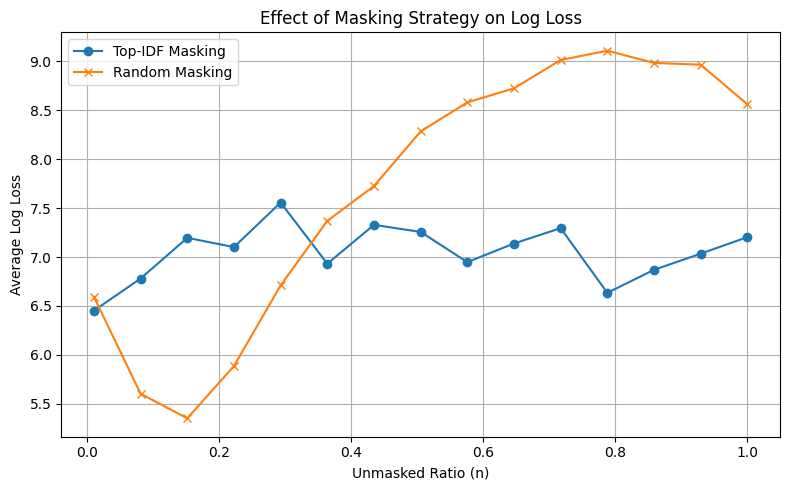

In [ ]:
#@title Results
#Comparing random masking vs pure top-idf
x, top_loss_curve, rand_loss_curve = sweep_masking_log_loss(
    eval_dataset,
    tokenizer,
    model,
    tokenid_to_priority,
    MASK_TOKEN_ID=126336,
    m=15,
    use_top_idf=True,
    use_random_masking=True,
    max_batches=30,
    idf_sample_ratio = 0.00001,
    plot_title="pretrained_no_resample"
)



=== Sweep step 1/15 | n = 0.01 ===
[Batch 6] → Top-IDF Loss Avg: 6.0339 | Random Loss Avg: 7.5898
[Batch 12] → Top-IDF Loss Avg: 5.8477 | Random Loss Avg: 7.0326
[Batch 18] → Top-IDF Loss Avg: 6.1840 | Random Loss Avg: 7.0512
[Batch 24] → Top-IDF Loss Avg: 6.3177 | Random Loss Avg: 7.2611
[Batch 30] → Top-IDF Loss Avg: 6.4521 | Random Loss Avg: 7.1214

=== Sweep step 2/15 | n = 0.08 ===
[Batch 6] → Top-IDF Loss Avg: 5.8763 | Random Loss Avg: 5.1315
[Batch 12] → Top-IDF Loss Avg: 5.4616 | Random Loss Avg: 4.9329
[Batch 18] → Top-IDF Loss Avg: 5.9891 | Random Loss Avg: 5.1762
[Batch 24] → Top-IDF Loss Avg: 6.2666 | Random Loss Avg: 5.4186
[Batch 30] → Top-IDF Loss Avg: 6.3086 | Random Loss Avg: 5.3570

=== Sweep step 3/15 | n = 0.15 ===
[Batch 6] → Top-IDF Loss Avg: 6.0026 | Random Loss Avg: 4.8711
[Batch 12] → Top-IDF Loss Avg: 5.9447 | Random Loss Avg: 4.7129
[Batch 18] → Top-IDF Loss Avg: 6.2687 | Random Loss Avg: 5.0395
[Batch 24] → Top-IDF Loss Avg: 6.3590 | Random Loss Avg: 5.3213

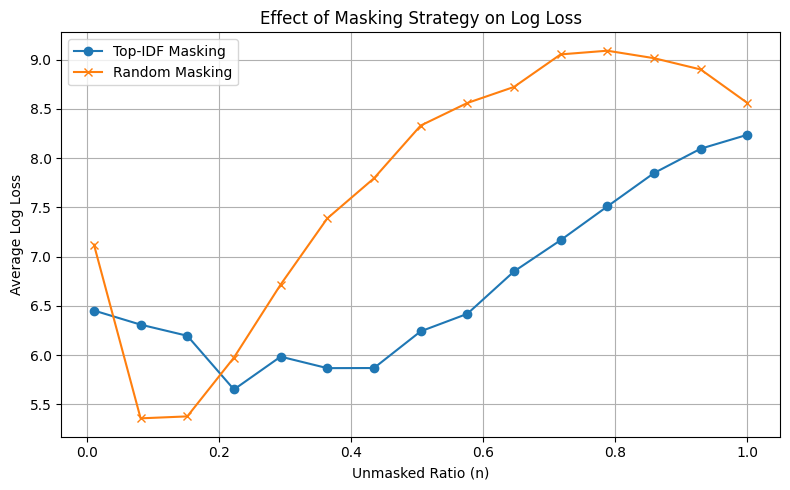

In [ ]:
#Comparing random masking vs top-idf + resample 50%
x, top_loss_curve, rand_loss_curve = sweep_masking_log_loss(
    eval_dataset,
    tokenizer,
    model,
    tokenid_to_priority,
    MASK_TOKEN_ID=126336,
    m=15,
    use_top_idf=True,
    use_random_masking=True,
    max_batches=30,
    plot_title=""
)


In [ ]:
#@title Helper Functions for Testing Manually Overriding IDF Values
from collections import defaultdict, Counter

#reports top tokens that remained unmasked to identify problematic tokens that shouldn't be unmasked first
def report_unmasked_token_stats(
    eval_dataset,
    tokenizer,
    tokenid_to_priority,
    MASK_TOKEN_ID,
    n,
    strategy="top_idf",
    max_batches=None,
    device="cuda",
    k=20
):
    token_unmasked_counts = Counter()
    token_total_counts = Counter()

    for i, batch in enumerate(eval_dataset):
        if max_batches is not None and i >= max_batches:
            break

        input_ids = batch["input_ids"].to(device)
        prompt_lengths = batch["prompt_length"].to(device)

        if input_ids.dim() == 1:
            input_ids = input_ids.unsqueeze(0)
        if prompt_lengths.dim() == 0:
            prompt_lengths = prompt_lengths.unsqueeze(0)

        input_ids_np = input_ids.cpu().numpy()

        for b in range(input_ids.size(0)):
            prompt_len = prompt_lengths[b].item()
            sequence = input_ids_np[b]
            answer_ids = sequence[prompt_len:]
            answer_len = len(answer_ids)

            if answer_len == 0:
                continue

            if isinstance(n, float):
                k_unmask = max(1, int(n * answer_len))
            else:
                k_unmask = min(n, answer_len)

            priorities = tokenid_to_priority[sequence]
            answer_priorities = priorities[prompt_len:]

            if strategy == "top_idf":
                keep_idx = np.argsort(answer_priorities)[-k_unmask:]
            elif strategy == "random":
                keep_idx = np.random.choice(answer_len, k_unmask, replace=False)
            else:
                raise ValueError("strategy must be 'top_idf' or 'random'")

            for i, tid in enumerate(answer_ids):
                token_total_counts[tid] += 1
                if i in keep_idx:
                    token_unmasked_counts[tid] += 1

    proportions = {
        tid: token_unmasked_counts[tid] / token_total_counts[tid]
        for tid in token_total_counts
    }

    sorted_tokens = sorted(proportions.items(), key=lambda x: -x[1])[:k]
    sorted_tokens = token_unmasked_counts.most_common(k)

    print(f"\nTop {k} tokens left unmasked by '{strategy}' masking (n={n}):")
    for tid, prop in sorted_tokens:
        token_str = tokenizer.decode([tid]).replace('\n', '⏎').strip()
        print(f"{token_str:<15} | Kept: {prop:.3f} | ID: {tid} | Count: {token_total_counts[tid]}")


In [ ]:
report_unmasked_token_stats(
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    tokenid_to_priority=run_priority,
    MASK_TOKEN_ID=tokenizer.mask_token_id or tokenizer.unk_token_id,
    n=0.1,
    strategy="top_idf",
    max_batches=None,
    k=25
)



Top 25 tokens left unmasked by 'top_idf' masking (n=0.1):
⏎               | Kept: 6142.000 | ID: 198 | Count: 8607
a               | Kept: 3259.000 | ID: 259 | Count: 3282
<|endoftext|>   | Kept: 1836.000 | ID: 126081 | Count: 22357
                | Kept: 434.000 | ID: 220 | Count: 1468
an              | Kept: 333.000 | ID: 289 | Count: 342
A               | Kept: 180.000 | ID: 355 | Count: 181
at              | Kept: 133.000 | ID: 482 | Count: 133
,               | Kept: 52.000 | ID: 11 | Count: 5503
.               | Kept: 44.000 | ID: 13 | Count: 4470
the             | Kept: 36.000 | ID: 268 | Count: 4424
and             | Kept: 34.000 | ID: 301 | Count: 3004
An              | Kept: 23.000 | ID: 1738 | Count: 23
ative           | Kept: 23.000 | ID: 1343 | Count: 24
.g              | Kept: 22.000 | ID: 2609 | Count: 34
ities           | Kept: 19.000 | ID: 1283 | Count: 19
to              | Kept: 19.000 | ID: 297 | Count: 2260
izing           | Kept: 18.000 | ID: 4489 | Count: 18
-b

In [ ]:
#Helper function to get idfs from token ids
def get_idfs_from_ids(token_ids, idf_dict, tokenizer):
    idf_results = {}

    for tid in token_ids:
        # Search in idf_dict by any (token, id) pair that matches the tid
        matches = [(tok, idf) for (tok, tok_id), idf in idf_dict.items() if tok_id == tid]
        if matches:
            # Use the first match found
            token_str, idf_val = matches[0]
            decoded = tokenizer.decode([tid]).replace("\n", "⏎").strip()
            print(f"Token: {decoded!r:<10} | ID: {tid:<6} | IDF: {idf_val:.5f}")
            idf_results[tid] = idf_val
        else:
            print(f"Token ID {tid} not found in idf_dict.")
            idf_results[tid] = None

    return idf_results
top_token_ids = [
    480, 6952, 5321, 56592, 363, 9, 31073, 8, 355, 0, 30, 197,
    1904, 126081, 373, 12, 13, 22170, 537, 1052, 1227, 943, 15,
    6374, 931
]

idf_values = get_idfs_from_ids(top_token_ids, idf_dict2, tokenizer)


Token: '**'       | ID: 480    | IDF: 0.55062
Token: 'Here'     | ID: 6952   | IDF: 0.59185
Token: '**'       | ID: 5321   | IDF: 0.55062
Token: '**:'      | ID: 56592  | IDF: 0.55062
Token: '('        | ID: 363    | IDF: 0.55062
Token: '*'        | ID: 9      | IDF: 0.55062
Token: ':**'      | ID: 31073  | IDF: 0.55062
Token: ')'        | ID: 8      | IDF: 0.55062
Token: 'A'        | ID: 355    | IDF: 0.91063
Token: '!'        | ID: 0      | IDF: 0.55062
Token: '?'        | ID: 30     | IDF: 0.55062
Token: ''         | ID: 197    | IDF: 0.79513
Token: '."'       | ID: 1904   | IDF: 0.55062
Token: '<|endoftext|>' | ID: 126081 | IDF: 0.55062
Token: '='        | ID: 373    | IDF: 0.55062
Token: '-'        | ID: 12     | IDF: 0.55062
Token: '.'        | ID: 13     | IDF: 0.55062
Token: 'Based'    | ID: 22170  | IDF: 0.81367
Token: '-'        | ID: 537    | IDF: 0.55062
Token: '",'       | ID: 1052   | IDF: 0.55062
Token: "'t"       | ID: 1227   | IDF: 0.50577
Token: '),'       | ID: 943  

In [ ]:
#tests how downweighting override token ids affects log loss, specifically you multiply override_token_ids[i]*override_values[j]

def sweep_idf_impact_over_values(
    eval_dataset,
    tokenizer,
    model,
    base_priority_array,
    override_token_ids,
    override_values=[0.05, 0.1, 0.2, 0.5, 0.9],
    MASK_TOKEN_ID=None,
    m=15,
    use_top_idf=True,
    use_random_masking=True,
    max_batches=30,
    device="cuda",
    seed=42,
    plot=True
):
    all_curves = []

    # Fix random seed
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    for val in override_values:
        print(f"\n==> Running sweep with override_value = {val}")

        run_priority = np.copy(base_priority_array)

        for tid in override_token_ids:
            if 0 <= tid < len(run_priority):
                run_priority[tid] = val
            else:
                print(f"[Warning] Token ID {tid} is out of bounds for priority array of size {len(run_priority)}")

        x, top_curve, rand_curve = sweep_masking_log_loss(
            eval_dataset=eval_dataset,
            tokenizer=tokenizer,
            model=model,
            tokenid_to_priority=run_priority,
            MASK_TOKEN_ID=MASK_TOKEN_ID,
            m=m,
            use_top_idf=use_top_idf,
            use_random_masking=use_random_masking,
            max_batches=max_batches,
            device=device
        )

        all_curves.append((val, top_curve, rand_curve))

    if plot:
        plt.figure(figsize=(8, 5))
        for val, top_curve, rand_curve in all_curves:
            if use_top_idf:
                plt.plot(x, top_curve, label=f"Top-IDF (override={val})", marker='o')
            if use_random_masking:
                plt.plot(x, rand_curve, label=f"Random (override={val})", marker='x')
        plt.xlabel("Unmasked Ratio (n)")
        plt.ylabel("Average Log Loss")
        plt.title("Effect of IDF Overrides on Masking Strategies")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return all_curves, x


In [ ]:
override_token_ids = [6952, 480, 5321, 56592, 363, 9, 31073, 8, 355, 0]  # e.g. top kept tokens
override_token_ids = [198, 259, 126081, 220, 289, 355, 482]
override_vals = [0.05, 0.1, 0.2, 0.3, 0.5, 0.9]

curves, x_vals = sweep_idf_impact_over_values(
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    model=model,
    base_priority_array=run_priority,
    override_token_ids=override_token_ids,
    override_values=override_vals,
    MASK_TOKEN_ID=126336,
    m=15,
    max_batches=30
)
